# How to evaluate a monitoring system for adaptive policies? Criteria for signposts selection and their model-based evaluation

## Application to the Niger River

*Based on the omonymous article, Climatic Change, by Raso et al, 2017

Author: Luciano Raso, Delft University of Technology, Delft, The Netherlands. Section of Policy Analysis   
email: l.raso@tudelft.nl

In [47]:
import numpy as np
#%matplotlib notebook 
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import pandas as pd
#import scipy.stats as stats
from scipy.stats import gumbel_r
from IPython.display import IFrame

### Policy problem

In [26]:
IFrame('../figures/Niger/Map_of_River_Niger_LR2.pdf', width=500, height=350)

The city of Niamey, capital of Niger, is located along the shore of the Niger River. The irregular flow of the river poses a risk of flood for the city. At the inception of the adaptive policy, in 1985, the levees at Niamey protect the city until a maximum discharge of 2000 $m^3/s$. A discharge above this threshold causes expensive inundations. 

In [27]:
q_flood = 2000 # m3/s

The river authority, the ``Autorité du Bassin du Fleuve Niger'' (ABN), prepares an adaptive policy to possible future changes. The ABN wanst to make sure that the hazard level, i.e. the yearly probability of flood, does not exceed the level presently acceptable, $F^*$: the frequency of inundation considered acceptable is below one over twenty-five years, i.e. $F^* <1/25$ $yr^{-1}$.

In [28]:
R_star = 25
F_star = 1/R_star

In the future, climate change may put at risk the capacity of levees to offer sufficient protection. 
The adaptive policy envisages the construction of higher levees if flood hazard exceed this value. These new levees would raise the maximum discharge to 2400 $m^3/s$. Raising the levees is an expensive action, therefore it will be taken only if justified by an increase in flood hazard. 

In [29]:
q_flood_action = 2700 #m^3/s

## Signposts

A signpost is a statistic, i.e. a rule that aggregates, transforms, or filters original data. 

In [30]:
class Signpost:
    def __init__(self,name,unit):
        self.name=name
        self.unit=unit
        self.ts=pd.DataFrame(None) #time series of signpost estimates
        self.statistic=[]
        self.trigger=[]

In the following analysis, we will compare two alternative monitoring systems based on a single signpost.

${S_E}$: Average of max yearly discharge at Niamey,
on a 15-year moving window.

In [31]:
S_E = Signpost(name='$S_E$',unit='$m^3/s$')
S_E.window = 15
S_E.statistic = lambda data: pd.Series(data).rolling(S_E.window).mean() #average value on S_E.window past data

${S_{10}}$: 9/10 quantile of max yearly discharge at Niamey, on a 30-year moving window. 

In [32]:
S_10=Signpost(name='$S_{10}$',unit='$m^3/s$')
S_10.window=30
S_10.quantile=9/10
S_10.statistic=lambda data: pd.Series(data).rolling(S_10.window).quantile(S_10.quantile)# general function, 9th decile on a window of 30 years

Parameters that $S_E$ and $S_{10}$ track are: 
$S_E$, Expected value of flood intensity at Niamey. 
$S_{10}$, 10-year return period flood at Niamey. 
$S_E$ has been selected because it is already used in flood protection policies, even if in a different context. $S_{10}$ has been selected for its closeness to the critical flood frequency. Comparing $S_{10}$ to $S_E$ we test whether a gain in relevance can compensate the loss in observability. 


### Additional material

Reviewer #1 suggested to test a signpost designed to detect the 25-year return period directly.
Following his/her suggestion, we added the signpost below

$S_\max$: Maximum value of max yearly discharge, on a 25-year moving window. 

In [33]:
S_max=Signpost(name='$S_\max$',unit='$m^3/s$')
S_max.window=25
S_max.statistic=lambda data: pd.Series(data).rolling(S_10.window).max() #, max value on a window of 25 years

## Model

The Generalized Extreme Value (GEV) model, that relates single data-points to system characteristics (i.e. model parameters) fits well for the scope of demonstrating the use of a model for signposts assessment. 

The GEV model [Coles, 2001] estimates the frequency of extreme events from maximum values over fixed periods. In flood frequency analysis, the period is generally a year, and the variable the max yearly discharge. A GEV model is defined by three parameters: location ($\mu$), scale ($\sigma$), and shape ($\xi$).

The critical assumptions are the location and scale parameters, $\mu$ and $\sigma$, which define the distribution. The shape parameter $\xi$ is particularly difficult to estimate from a short time series, requiring a much longer horizon than the period for which we have data, or some regional analysis [Panthou et al., 2012]. 
To reduce ambiguity in data interpretation, we will constrain the shape parameter assuming it to be zero. In this case the GEV reduces to a Gumbel distribution, a.k.a. GEV type III. 

In [34]:
model = gumbel_r   # define model

Equation below represents the Gumbel distribution.
$$ F(x)= e^{-e^{\frac{-q-\mu}{\sigma}}} $$  

where $q$ is the yearly maximum discharge, $\mu$ and $\sigma$ the location and scale parameter. The Gumbel distribution is equivalent to a Generalized Extreme Value distribution for $\xi=0$, a.k.a. Type-I GEV.


Estimated on historical data until 1970, find $\mu_h=1150$ $m^3/s$  and $\sigma_h=170$ $m^3/s$

In [35]:
mu_hist = mu_hist_85 = 1150 #m3/s
sigma_hist = sigma_hist_85 = 170 #m3/s

The GEV is a stochastic model whose model parameters are generally estimated from historical time series, assuming stationary conditions. Here, instead, we use the GEV in an exploratory mode, i.e. we explore the model response for a large set of critical assumptions. 

Changed, over time, reaching $\mu_h=600$ $m^3/s$  and $\sigma_h=240$ $m^3/s$

In [37]:
sigma_all = np.arange(0,400)
mu_all = np.arange(q_flood,0,-1) 

Explore critical region for different values of $\mu$ and $\sigma$. Exploratory modeling, or stress test. 

### Critical Region

The boundary of the critical region in $\mu$ and $\sigma$ is the set of $[\mu^*,\sigma^*]$, space in $R^2$, can be found by inverting Equation (\ref{gumbel}), conditioning the flood frequency to be equal to the critical flood frequency, i.e. $F=F^*$, and the discharge equal to the flood threshold level, i.e. $q=q_{flood}$. Then one can find the relation at Equation
\begin{equation}\label{F_star}
\mu^*= q_{flood} \hspace{3mm} + \hspace{3mm} \log \Bigg(-\log \Big(1-{F^*}\Big)\Bigg) \cdot \sigma^*
\end{equation}
In the equation above, the relation [$\mu^*,\sigma^*$] is a straight line, in which $q_{flood}$ is the intercept for $\sigma=0$, and $\log(-\log\left(1- {F^*}\right))$ its slope. 


In [45]:
def critical_region(q_flood,F_star,hist=[],**kwargs):
    """"
    Create stress-test plot (critical region), for a given discharge threshold level of protection  
    """
    
    mu_all= np.arange(q_flood,0,-1) 
    slope= 1 / np.log(-np.log(1-F_star)) 
    sigma_critic = (mu_all - q_flood ) * slope
    
    # set plot boundaries 
    mu_limit = [q_flood*0.4,q_flood*1.05]
    sigma_max = (q_flood*0.4 - q_flood ) * slope
    sigma_limit = [0,sigma_max*1.1]
    sigma_center = (q_flood*0.65 - q_flood ) * slope

    # create plot
    plt.plot(mu_all,sigma_critic,color='b',label='$F^*$ Frequency')
    plt.xlabel('Location $\mu$ $[m^3/s]$',fontsize=12)
    plt.ylabel('Scale $\sigma$ $[m^3/s]$',fontsize=12 )
    plt.title('Stress Test',fontsize=18)

    if hist is not []:
        plt.plot(hist[0],hist[1],marker='o')
    #ax.annotate('1985', xy=(mu_hist_85, sigma_hist), xytext=(mu_hist_85-200, sigma_hist),arrowprops=dict(facecolor='black', shrink=0.01))
        plt.text(hist[0]*1.02,hist[1]*0.95, 'Historical',fontsize=12)

    plt.text(mu_limit[1]*0.76, sigma_max*0.95, 'Failure Region ($F>F^*$)',fontsize=12,
            bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})
    plt.text(mu_limit[0]*1.05, 50, 'Success Region ($F<F^*$)',fontsize=12,
            bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})
    plt.text(q_flood*0.65, sigma_center, '$F^*$ Frequency ',color='b',fontsize=14)

    plt.xlim(mu_limit)
    plt.ylim(sigma_limit)



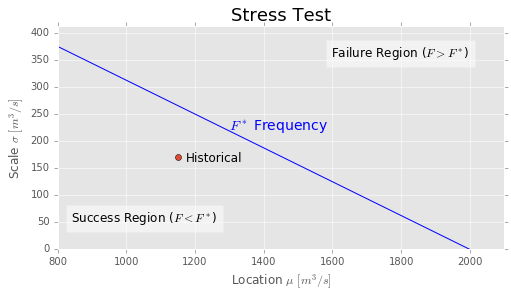

In [49]:
# plot critical region
fig = plt.figure(figsize=(8,4))
critical_region(q_flood,F_star,hist=[mu_hist,sigma_hist])
#plt.savefig("../Figures/critical_region.pdf")
plt.show()

Figure above shows the ``critical region'', i.e. the policy success region for all possible values of critical assumptions. The blue line in the figure correspond to the boundary of policy success: if both $\mu$ and $\sigma$ fall below it, the policy is successful, otherwise there is a need for action. The frontier line corresponds to the critical flood frequency $F^*=1/25$ $yrs^{-1}$. This line can be derived analytically, as described in the procedure in [Raso et al].
The red point in the figure represents the location and scale parameters estimated from historical data until 1985. 


### Signposts Analysis

The critical assumptions are the location and scale parameters, $\mu$ and $\sigma$, which define the distribution. We analyse here the signpost response when parameters change.

In [50]:
#plot
def signpost_analysis_plot (signpost,par_name,par,S_mean,S_up,S_low):
    plt.plot(par,S_mean, label='average',color='b')
    plt.plot(par,S_up,ls='--',color='b',label='90% uncertainty band')
    plt.plot(par,S_low,ls='--',color='b')
    #unc=plt.fill_between(par,S_up, S_low,color='gray',label='uncertainty band')
    plt.xlabel(par_name+' $[m^3/s]$',fontsize='15')
    plt.ylabel(signpost.name +' ['+ signpost.unit +']',fontsize='15')
    plt.title(signpost.name + ' vs ' + par_name)
    plt.legend(loc='lower right')
    #plt.gca().set_ylim(bottom=0)
    #plt.gca().set_xlim(left=0)
    plt.grid(True) 

#### $S_E$ variation to Model Parameters

In [51]:
# Model exploratory
mu_expl=mu_all[::-1]
sigma_expl = sigma_all
model_expl_mu=model.freeze(loc=mu_expl,scale=sigma_hist)
model_expl_sigma=model.freeze(loc=mu_hist,scale=sigma_all)

In [55]:

confidence = .90
conf = 1.64 # 1.15 = 75%  1.64: 90%

# S_E vs mu
S_E_mu_mean = model_expl_mu.mean()
S_E_mu_var = model_expl_mu.var()/S_E.window
S_E_mu_up=S_E_mu_mean + conf*np.sqrt(S_E_mu_var)
S_E_mu_low=S_E_mu_mean - conf*np.sqrt(S_E_mu_var)


#S_E vs sigma
S_E_sigma_mean=model_expl_sigma.mean()
S_E_sigma_var=model_expl_sigma.var()/S_E.window
S_E_sigma_up=S_E_sigma_mean + conf*np.sqrt(S_E_sigma_var)
S_E_sigma_low=S_E_sigma_mean - conf*np.sqrt(S_E_sigma_var)

# Signpost confidence
S_E.confidence_range_up=conf*np.sqrt(S_E_mu_var[sigma_hist-1])
S_E.confidence_range_low=conf*np.sqrt(S_E_mu_var[sigma_hist-1])

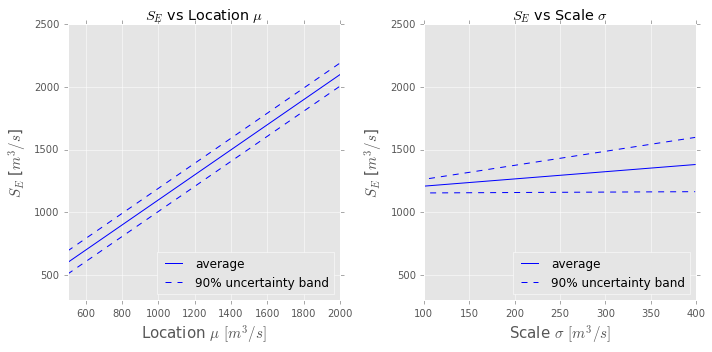

In [56]:
f, (ax_mu, ax_sigma) = plt.subplots(1,2,sharey=True,figsize=(10,5))
plt.figure(1)
ax_mu=plt.subplot(121)
signpost_analysis_plot (S_E,'Location $\mu$',mu_expl,S_E_mu_mean,S_E_mu_up,S_E_mu_low)
plt.xlim(500)
plt.ylim((300,2500))
ax_sigma=plt.subplot(122)
plt.xlim([100,400])
ylim = ax_mu.get_ylim()
ax_sigma.set_ylim(ylim)
signpost_analysis_plot (S_E,'Scale $\sigma$',sigma_all,S_E_sigma_mean,S_E_sigma_up,S_E_sigma_low)
f.tight_layout()
plt.savefig("../Figures/Niger/S_E.pdf")


#### $S_{10}$ variation to Model Parameters
$S_{10}$ variance: Knowing the convergence of empirical distribution , i.e. $\hat{F}_n(t)  \rightarrow N \left(F(t), \frac{F(t)\cdot (1-F(t))}{n}\right)$, where $\hat{F}_n(t)$ is the empirical distribution, $F(t)$ the original one, $t$ the quantile and $n$ the sample size. $S_{10}$ is the distributed $F^{-1}\left(\hat{F}_n\left(\frac{9}{10}\right)\right)$

In [58]:
sigma_F_hat = np.sqrt((S_10.quantile)*(1-(S_10.quantile))/S_10.window)
#+conf*sigma_F_hat+S_10.quantile #check

In [59]:
#analytical
#S_10 vs mu
S_10_mu_mean = model_expl_mu.ppf(S_10.quantile)
S_10_mu_up=model_expl_mu.ppf(S_10.quantile+conf*sigma_F_hat)
S_10_mu_low=model_expl_mu.ppf(S_10.quantile-conf*sigma_F_hat)

#S_10 vs sigma
S_10_sigma_mean=model_expl_sigma.ppf(S_10.quantile)
S_10_sigma_up=model_expl_sigma.ppf(S_10.quantile+conf*sigma_F_hat)
S_10_sigma_low=model_expl_sigma.ppf(S_10.quantile-conf*sigma_F_hat)

# Signpost confidence
S_10.confidence_range_up=S_10_mu_up[sigma_hist-1]-S_10_mu_mean[sigma_hist-1]
S_10.confidence_range_low=-S_10_mu_low[sigma_hist-1]+S_10_mu_mean[sigma_hist-1]

/Users/lraso/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1907: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/Users/lraso/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1908: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


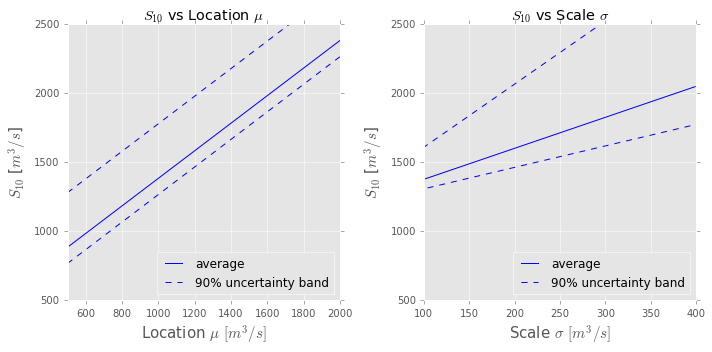

In [72]:
#plot
f,  (ax_muax_mu,  ax_sigmaax_sigma) = plt.subplots(1,2,sharey=True,figsize=(10,5))
ax_mu = plt.subplot(121)
signpost_analysis_plot (S_10,'Location $\mu$',mu_expl,S_10_mu_mean,S_10_mu_up,S_10_mu_low)
plt.xlim(500)
plt.ylim((500,2500))
ax_sigma = plt.subplot(122)
plt.xlim([100,400])
ylim = ax_mu.get_ylim()
ax_sigma.set_ylim(ylim)
signpost_analysis_plot (S_10,'Scale $\sigma$',sigma_all,S_10_sigma_mean,S_10_sigma_up,S_10_sigma_low)
f.tight_layout()
#plt.savefig("../Figures/S_10.pdf")


### Additional material
Analysis for signpost $S_\max$

The convergence rule to estimate the quantiles distribution cannot be used for this signpost, the therefore we use here a montecarlo approach.

In [73]:
sample_size = 15000

q_yearVSmu_random = model_expl_mu.rvs(size=(S_max.window,sample_size,len(mu_expl)))
q_yearVSsigma_random = model_expl_sigma.rvs(size=(S_max.window,sample_size,len(sigma_expl)))


#S_max vs sigma
#model_expl_sigma
# Signpost confidence

In [74]:
S_maxVSmu_random = np.max(q_yearVSmu_random,axis=0)
S_maxVSsigma_random = np.max(q_yearVSsigma_random,axis=0)


In [78]:
#S_max vs mu
S_max_mu_mean = np.mean(S_maxVSmu_random,axis=0)
S_max_mu_up = np.percentile(S_maxVSmu_random, (confidence+1)/2*100,axis=0)
S_max_mu_down = np.percentile(S_maxVSmu_random, (1-confidence)/2*100,axis=0 )


#S_max vs sigma
S_max_sigma_mean = np.mean(S_maxVSsigma_random,axis=0)
S_max_sigma_up = np.percentile(S_maxVSsigma_random, (confidence+1)/2*100,axis=0)
S_max_sigma_down = np.percentile(S_maxVSsigma_random, (1-confidence)/2*100,axis=0 )

# Signpost confidence
S_max.confidence_range_up=S_max_mu_up[mu_hist-1]-S_max_mu_mean[mu_hist-1]
S_max.confidence_range_low=-S_max_mu_low[mu_hist-1]+S_max_mu_mean[mu_hist-1]


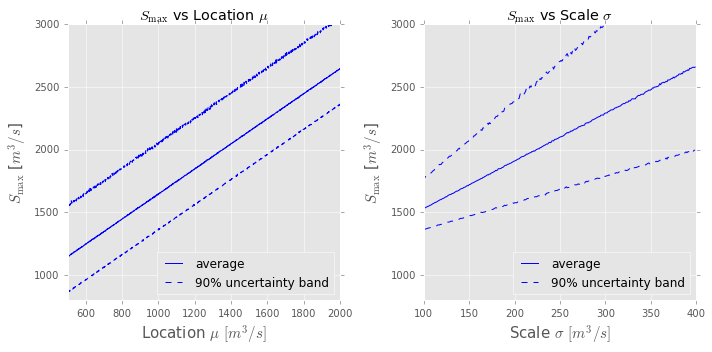

In [80]:
f, (ax_mu, ax_sigma) = plt.subplots(1,2,sharey=True,figsize=(10,5))
plt.figure(1)
ax_mu=plt.subplot(121)
signpost_analysis_plot (S_max,'Location $\mu$',mu_expl,S_max_mu_mean,S_max_mu_up,S_max_mu_down)
plt.xlim(500)
plt.ylim((800,3000))
ax_sigma=plt.subplot(122)
plt.xlim([100,400])
ylim = ax_mu.get_ylim()
ax_sigma.set_ylim(ylim)
signpost_analysis_plot (S_max,'Scale $\sigma$',sigma_all,S_max_sigma_mean,S_max_sigma_up,S_max_sigma_down)
f.tight_layout()
#plt.savefig("../Figures/Niger/S_max.pdf")


### Trigger Values Selection

A trigger is the signpost value at which adaptation is required. In the test case, policy requires adaptation if flood frequency $F$ exceeds the threshold level $F^*$, of one over 25 years. Flood frequency level corresponds to a [$\mu^*,\sigma^*$], that is a 2-dimensional space in model parameters.

Trigger points are selected by sampling three equidistant combinations of location and scale parameter from the parameters space, in proximity of the parameters historically observed. Then, the three sets of parameters are mapped over the expected signpost values, finding the signpost values that would be measured, on average, for each set of parameters. 

In [86]:
sigma_trigger = np.linspace(150.,270.,num=5)[1:-1] #three levels.
mu_trigger = q_flood + np.log (-np.log(1-F_star) ) * sigma_trigger
model_expl_trigger=model.freeze(loc=mu_trigger,scale=sigma_trigger)

In [87]:
S_E.trigger = model_expl_trigger.mean()
S_10.trigger = model_expl_trigger.ppf(S_10.quantile)
S_max.trigger = model_expl_trigger.ppf(24/25)

## Signposts in action

In [88]:
real_data=1

Loading observed data, or create artificial ones. 

In [89]:
if real_data:
    q_max_df = pd.read_csv('../data/Niger/rbflood_updated.csv',index_col='year')
    # TRY ELSE load max discharge data. 
else: #artificial data
    half_data_length = 30
    mu_artificial = concatenate([half_data_length*[mu_hist] , mu_hist+(mu_present-mu_hist)*arange(0,half_data_length)/half_data_length])
    sigma_artificial = concatenate([half_data_length*[sigma_hist], sigma_hist+(sigma_present-sigma_hist)*arange(0,half_data_length)/half_data_length])
    model_artificial = model.freeze(loc=mu_artificial,scale=sigma_artificial)
    q_data=model_artificial.rvs()
    
    rng = pd.date_range('1/1/1950', periods=half_data_length*2, freq='A')
    q_max_ts = pd.DataFrame(q_data, index=rng)

In [90]:
q_max_df_cut=q_max_df['red_flood_max'].loc[1950:2013] 

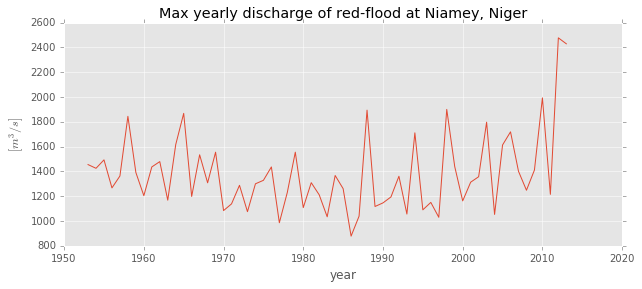

array([1800.88494383, 1772.43993581])

In [96]:
plt.figure(figsize=(10,4))
plt.plot(q_max_df_cut.loc[:2013])
plt.xlabel('year')
plt.ylabel('$[m^3/s]$')
plt.title('Max yearly discharge of red-flood at Niamey, Niger')
plt.show()

S_10.trigger[1:]

#### Calculate signposts estimate over time

In [93]:
S_E.ts= S_E.statistic(q_max_df_cut)#.apply(S_E.statistic)
S_10.ts =S_10.statistic(q_max_df_cut)
S_max.ts = S_max.statistic(q_max_df_cut)

#### Signpost value: plot over time
Confidence range: band considering $\mu_{hist},\sigma_{hist}$, and confidence 90%

In [97]:
def signpost_over_time(signpost,start_date,end_date):
  
    ts_period=signpost.ts.loc[start_date:end_date]
    plt.fill_between(ts_period.index,ts_period-signpost.confidence_range_low, ts_period+signpost.confidence_range_up,color='0.65',label='90% uncertainty band')
    
    
    sign=plt.plot(ts_period,label='Signpost value',linewidth=2,color='b')
    
    plt.title(signpost.name + ' over time')
    plt.ylabel(signpost.name+' ['+ signpost.unit+ ']',fontsize='15')
    plt.xlabel('Year',fontsize='15')
    pos_text=0.9*(plt.gcf().gca().get_xlim()[1])+0.1*(plt.gcf().gca().get_xlim()[0])
    
    trigger_line=plt.axhline(y=signpost.trigger[0],ls='--', color='k',label='Trigger values')
    for trigger_value in signpost.trigger[1:]: 
        trigger_line=plt.axhline(y=trigger_value,ls='--', color='k')
        #plt.text(pos_text,trigger_value,str("{0:.0f}".format(trigger_value)))
    plt.gca().set_xlim(right=2015)
    plt.legend(loc='upper left') 
    plt.grid(True)
    #plt.xlim((signpost.ts.index[0], 2015))

Signpost $S_E$ over time

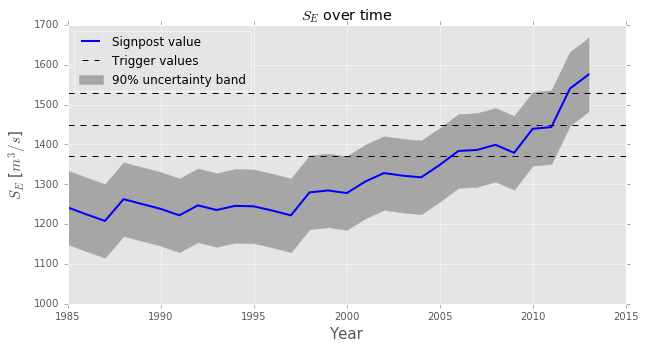

In [102]:
START_DATE = 1985
END_DATE = 2013
plt.figure(figsize=(10,5))
signpost_over_time(S_E,START_DATE,END_DATE) 
plt.ylim([1000,1700])
#plt.savefig("../Figures/S_E_overtime.pdf")
plt.show()

Signpost $S_{10}$ over time

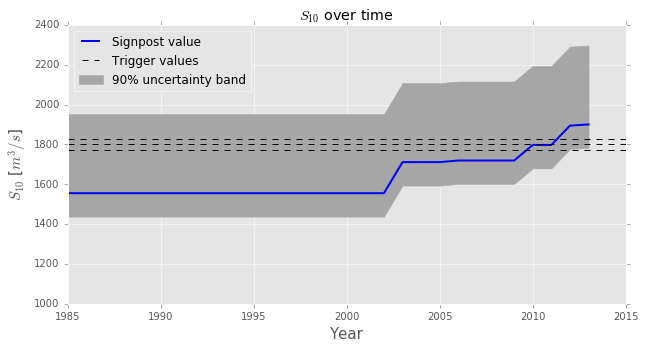

In [106]:
plt.figure(figsize=(10,5))
signpost_over_time(S_10,START_DATE,END_DATE)
plt.ylim([1000,2400])
#plt.savefig("../Figures/Niger/S_10_overtime.pdf")
plt.show()

Signpost $S_{\max}$ over time

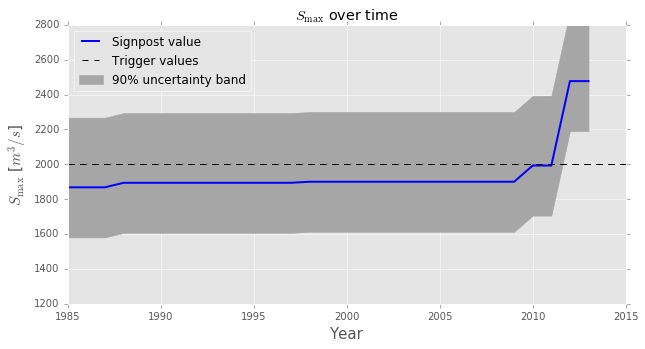

In [104]:
plt.figure(figsize=(10,5))
signpost_over_time(S_max,START_DATE,END_DATE)
plt.ylim([1200,2800])
#plt.savefig("../Figures/Niger/S_max_overtime.pdf")
plt.show()

(1200, 3000)

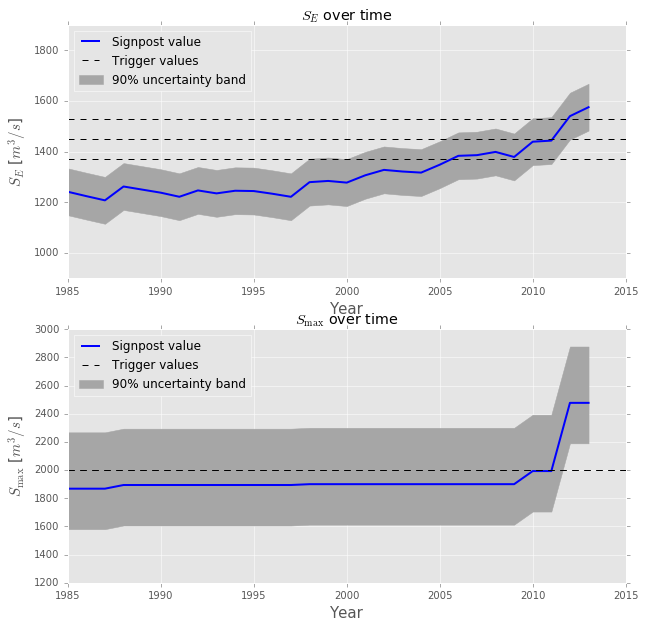

In [105]:
f = plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
signpost_over_time(S_E,START_DATE,END_DATE)
plt.ylim([900,1900])

plt.subplot(2, 1, 2)
signpost_over_time(S_max,START_DATE,END_DATE)
plt.ylim([1200,3000])
#plt.savefig("../Figures/Niger/S_overtime.pdf")
